### MNISTの画像を準備

超解像復元の問題は、(連続状態集合S, 可算有限行動集合A, 報酬関数R, 不明な遷移関数T, 初期状態の生起確立P)からなるマルコフ決定過程で表され、高解像の復元画像を表す各状態を表す$s \in \mathbb{R}^{h \times w}$に顕微鏡でのぼやけ具合を表すフィルタを畳み込んだ値と、目標値である低解像度画像$ b \in \mathbb{R}^{(h - p + 1) \times (w - q + 1)}$との差を用いた報酬
$$ R = - \| s - b \|^2 $$
の総和を最大化するような、適切な行動(フィルタ)を決定的方策を学習する課題であると見なす事ができる。 

ここで、問題になるのは、状態集合が連続値で、一回の決定でたどり着ける状態とたどり着けない状態が存在も存在するし、さらには初期状態によって永遠にたどり着けない状態も存在する事である。この問題を解消しないと詰むのでは？  
-> 周期性のないマルコフ決定過程が強化学習問題において、問題なく最適な決定的方策を学習する事ができうるのかを調べる。

In [5]:
from matplotlib import pyplot as plt
import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from scipy.signal import fftconvolve


device = tc.device('cuda:0')

In [6]:
# データは num = 0の画像のみ
transform = transforms.Compose([transforms.ToTensor()])
whole_trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
train_mask = (whole_trainset.targets == 0).nonzero()[:, 0]
trainset = Subset(whole_trainset, train_mask)

whole_testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
test_mask  = (whole_testset.targets == 0).nonzero()[:, 0]
testset = Subset(whole_testset, test_mask)
trainloader = DataLoader(trainset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

In [62]:
import numpy as np
from scipy.stats import multivariate_normal
from skimage.restoration import wiener

# 準備するフィルタのサイズを5x5に固定
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
std = 0.8
gauss_filters = []
for i in range(1, 3):
    f = np.vectorize(
        lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std*i]*2)).pdf([x, y])
    )
    kernel = f(X, Y)
    kernel = kernel / kernel.sum()
    kernel = kernel.astype(np.float32)
    gauss_filters.append(kernel)
gauss1 = gauss_filters[0]
gauss2 = gauss_filters[1]

In [88]:
# フィルタのリスト(sharpen, unsharpen, gaussian_blur)
sharpen = 1.0 * tc.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

unsharpen = (-1) * tc.tensor([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
]) / 256.0

actions = [
    lambda x: fftconvolve(x, gauss1, mode='same'),
#     lambda x: fftconvolve(x, unsharp, mode='same'),
    lambda x: fftconvolve(x, gauss2, mode='same'),
    lambda x: wiener(x, gauss1, 1e-4),
]
action_labels = ['gauss1', 'gauss2', 'wiener']

### 以下環境

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 4, 5)
        self.conv_transpose1 = nn.ConvTranspose2d(4, 8, 5)
        self.conv_transpose2 = nn.ConvTranspose2d(8, 1, 5)
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
        
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        return x
    
AE_MNIST = AutoEncoder()
AE_MNIST.load_state_dict(tc.load('AE_mnist20x20.pth'))
AE_MNIST.to(device)

AutoEncoder(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv_transpose1): ConvTranspose2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv_transpose2): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [2]:
import torch as tc
tc.cat([tc.rand(2,3,4), tc.rand(2,3,4)]).shape

torch.Size([4, 3, 4])

In [108]:
T = 3
class InnerState(object):
    def __init__(self, now_img, init_img):
        # init_stateはスカラにしたほうがいい？
        if not tc.is_tensor(now_img):
            now_img = tc.tensor(now_img).to(device)
        if not tc.is_tensor(init_img):
            init_img = tc.tensor(init_img).to(device)
        self.x = tc.stack([now_img, init_img])
    
    @property
    def now(self):
        return self.x[0]
    
    @property
    def init(self):
        return self.x[1]     

# 最終的には、これがオートエンコーダーで特徴量抽出したものになる。
class OuterState(object):
    def __init__(self, inner_state):
        # Add chunnel
        with tc.no_grad():
            now = inner_state.now.unsqueeze(0).unsqueeze(0)
            now = AE_MNIST.encode(now).squeeze(0)
            init = inner_state.init.unsqueeze(0).unsqueeze(0)
            init = AE_MNIST.encode(init).squeeze(0)
        self.v = tc.cat([now, init])
        
        
class ReconstructionEnv(object):
    def __init__(self, train=True):
        self._state = None
        self.train = train
        self._step_count = 0
    
    def reset(self):
        '''
        数字が0のデータからサンプルを選んでくる。
        1)targetとなる画像を、self._bに
        2)targetをぼかした画像を、self._stateにセット
        '''
        self._step_count = 0
        
        #1) 目標画像の準備
        if self.train:
            self._b = next(iter(trainloader))[0]
        else:
            self._b = next(iter(testloader))[0]
        self._b = self._b.squeeze(0).squeeze(0).to(device)
        #2) ぼかした画像と初期の画像を2チャンネルで持った画像にしてみる
        self.init_state = self._b.cpu().numpy()
        for _ in range(3):
            self.init_state = fftconvolve(self.init_state, gauss1, mode='same')
        self.init_state = tc.tensor(self.init_state).to(device)
        self._state = InnerState(self.init_state, self.init_state)
        
    @property
    def state(self):
        return OuterState(self._state)
    
    def next_state(self, action):
        linear_restore = tc.tensor(action(self._state.now.cpu().numpy())).to(device, dtype=tc.float)
        non_linear_restore = F.relu(linear_restore)
        return InnerState(non_linear_restore, self.init_state)
    
    def reward_func(self, state, next_state):
        # TODO: 報酬関数を以下のように設計
        # * 元々指定した再構成誤差よりも小さくなったら正の報酬
        # * 元の復元回数Tを超えたらペナルティ
        return -tc.sum((self._b - next_state.now)**2)
    
    def step(self, a):
        self._step_count += 1  # インクリメント
        action = actions[a]
        next_state = self.next_state(action)
        reward = self.reward_func(self._state, next_state)
        done = (self._step_count == T)  # 5回フィルタをかけたら終わり
        self._state = next_state  # そのまま代入して大丈夫。今回の環境では次の状態が常に存在するので。
        return OuterState(next_state), reward, done

### AgentにValueベースの方策を学習させて行動評価させる

In [139]:
LAST_FILTER_WIDTH = 2
class ConvQualityFunction(nn.Module):
    def __init__(self, action_dim):
        super(ConvQualityFunction, self).__init__()
        self.conv1 = nn.Conv2d(8, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, action_dim)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH)
        x = F.relu(
            self.dropout1(self.fc1(x))
        )
        x = F.relu(
            self.dropout2(self.fc2(x))
        )
        return self.fc3(x)


class DQNAgent(object):
    def __init__(self, action_dim=3, eps=0.1, lr=0.1, gamma=0.9):
        self.action_dim = action_dim
        self.eps = eps
        self.gamma = gamma
        self.Q_function = ConvQualityFunction(action_dim)
        self.Q_function.to(device)
        self.teacher_model = ConvQualityFunction(action_dim)
        self.teacher_model.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.Q_function.parameters(), lr=lr)
    
    def policy(self, state, train=False):
        if train and tc.rand(()) < self.eps:
            return tc.randint(self.action_dim, ())
        with tc.no_grad():
            action_qualities = self.Q_function(state.v.unsqueeze(0))
        # Valueベースでactionを決定する
        print(action_qualities.shape)
        raise
        return tc.argmax(action_qualities)
    
    def update(self, batch):
        # Experience Replayに基づいて行動評価関数のパラメーターを更新する。
        estimation_qualities = []
        true_qualities = []
        for i, e in enumerate(batch):
            est = self.Q_function(e.s.v.unsqueeze(0)).squeeze(0)
            v = e.r
            if not e.d:
                with tc.no_grad():
                    v += self.gamma * tc.max(self.teacher_model(e.ns.v.unsqueeze(0)).squeeze(0))
            estimation_qualities.append(est[e.a])
            true_qualities.append(v)
        estimation_qualities = tc.stack(estimation_qualities)
        true_qualities = tc.tensor(true_qualities).to(device)
        self.optimizer.zero_grad()
        loss = self.criterion(estimation_qualities, true_qualities)
        loss.backward()
        self.optimizer.step()
    
    def update_teacher(self):
        self.teacher_model.load_state_dict(self.Q_function.state_dict())

In [135]:
import random
from tqdm.notebook import tqdm
from collections import deque, namedtuple
Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))

def moving_average(r, n=100):
    ret = tc.cumsum(r, dim=0, dtype=tc.float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(agent, seed=0, train_episode_num=10000, teacher_freq=3, n=100):
    experiences = deque(maxlen=1024)
    train_count = 0
    reward_records = []
    
    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        env = ReconstructionEnv()
        env.reset()
        done = False
        while not done:
            action = agent.policy(env.state, train=True)
            next_state, reward, done = env.step(action)
            e = Experience(env.state, action, next_state, reward, done)
            experiences.append(e)
            Ri += reward
            
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            agent.update(batch)
            train_count += 1
        
        if train_count % teacher_freq == 0:
            agent.update_teacher()
        
        reward_records.append(Ri)
    
    plt.plot(moving_average(tc.tensor(reward_records), n=n), label='got reward while training')
    plt.legend(loc='best')
    return reward_records

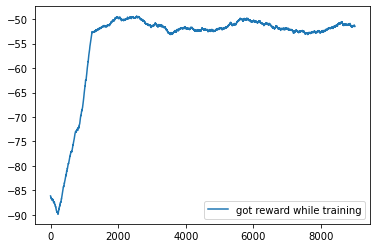

In [138]:
seed = 0
random.seed(seed)
tc.random.manual_seed(seed)
agent = DQNAgent(eps=0.3, lr=0.1)
rewards = train(agent, train_episode_num=10000, n=1000)

In [121]:
def test_policy(agent=None, fixed_action=None, randomize=False):
    env = ReconstructionEnv()
    env.reset()
    done = False
    fig = plt.figure(figsize=(2, 2))
    plt.title('original')
    plt.imshow(env._b.cpu())
    plt.axis('off')
    plt.show()
    
    fig = plt.figure(figsize=(20, 2))
    plt.subplot(1, T + 1, 1)
    plt.axis('off')
    plt.imshow(env._state.now.cpu())
    print('回数 = ', T)
    took_actions = []
    reward_sum = 0
    while not done:
        if fixed_action is not None:
            a = fixed_action
        elif randomize:
            a = tc.randint(4, ()).to(device)
        else:
            a = agent.policy(env.state)
        took_actions.append(action_labels[a])
        next_state, reward, done = env.step(a)
        plt.subplot(1, T + 1, env._step_count + 1)
        plt.axis('off')
        plt.imshow(env._state.now.cpu())
        reward_sum += reward
        print(f'loss of step({env._step_count})', tc.sum((env._b - env._state.now)**2).item(), end='//')
    print()
    print('reward_sum: ', reward_sum.item())
    plt.show()
    print(took_actions)

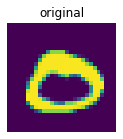

回数 =  3
loss of step(1) 16.44525909423828//loss of step(2) 8.77673625946045//loss of step(3) 7.3117241859436035//
reward_sum:  -32.533721923828125


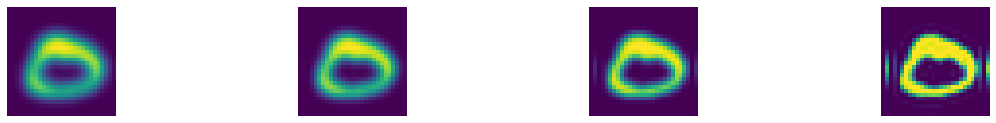

['wiener', 'wiener', 'wiener']


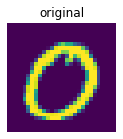

回数 =  3
loss of step(1) 20.55320167541504//loss of step(2) 10.887350082397461//loss of step(3) 12.306035995483398//
reward_sum:  -43.74658966064453


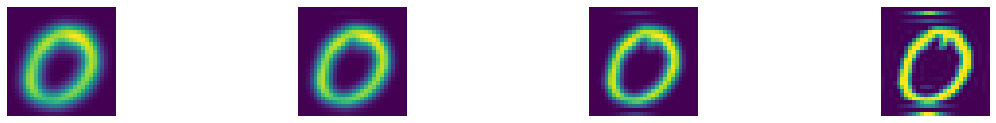

['wiener', 'wiener', 'wiener']


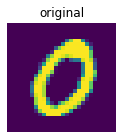

回数 =  3
loss of step(1) 16.163103103637695//loss of step(2) 8.201529502868652//loss of step(3) 1.4943106174468994//
reward_sum:  -25.85894203186035


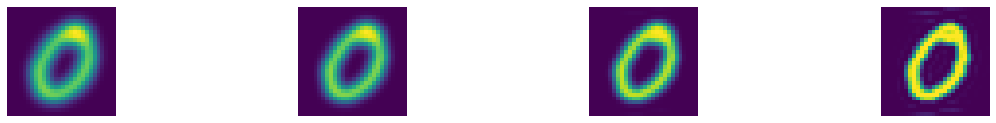

['wiener', 'wiener', 'wiener']


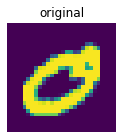

回数 =  3
loss of step(1) 17.200834274291992//loss of step(2) 9.279382705688477//loss of step(3) 1.7713980674743652//
reward_sum:  -28.251615524291992


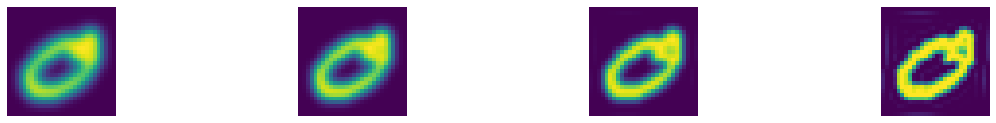

['wiener', 'wiener', 'wiener']


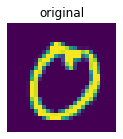

回数 =  3
loss of step(1) 22.331321716308594//loss of step(2) 12.153511047363281//loss of step(3) 11.439796447753906//
reward_sum:  -45.92462921142578


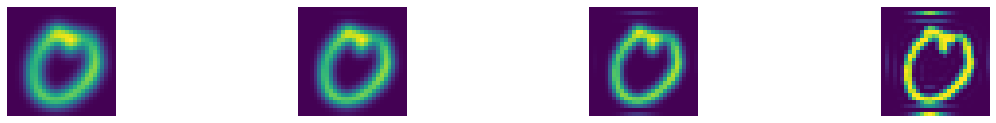

['wiener', 'wiener', 'wiener']


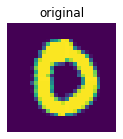

回数 =  3
loss of step(1) 13.22017765045166//loss of step(2) 7.014598369598389//loss of step(3) 1.3460115194320679//
reward_sum:  -21.580787658691406


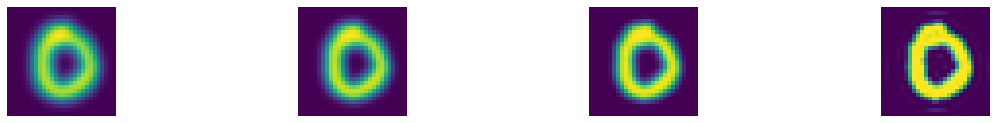

['wiener', 'wiener', 'wiener']


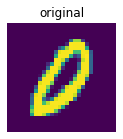

回数 =  3
loss of step(1) 16.359573364257812//loss of step(2) 8.349163055419922//loss of step(3) 1.581197738647461//
reward_sum:  -26.289934158325195


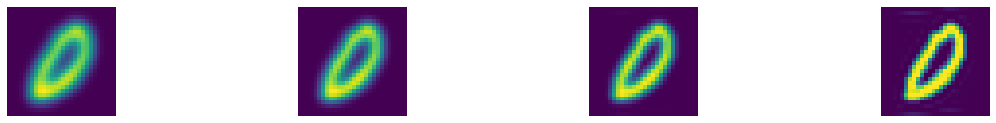

['wiener', 'wiener', 'wiener']


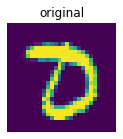

回数 =  3
loss of step(1) 18.01144027709961//loss of step(2) 9.846733093261719//loss of step(3) 9.136286735534668//
reward_sum:  -36.99446105957031


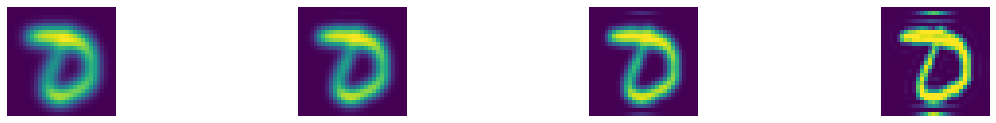

['wiener', 'wiener', 'wiener']


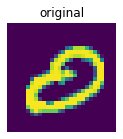

回数 =  3
loss of step(1) 20.945758819580078//loss of step(2) 11.22615909576416//loss of step(3) 13.817919731140137//
reward_sum:  -45.989837646484375


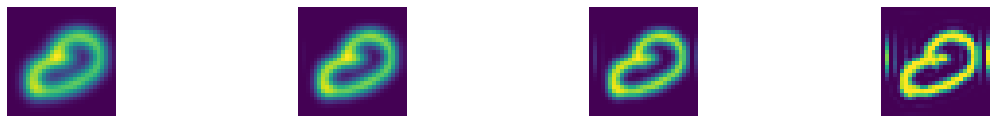

['wiener', 'wiener', 'wiener']


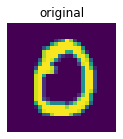

回数 =  3
loss of step(1) 17.927688598632812//loss of step(2) 9.171981811523438//loss of step(3) 1.2169723510742188//
reward_sum:  -28.31664276123047


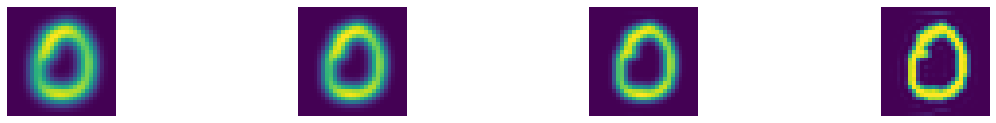

['wiener', 'wiener', 'wiener']


In [140]:
for i in range(10):
    test_policy(agent)

In [ ]:
# スコアの平均値を比較しておく
tc.random.seed(0)
sum_info = {'gauss1': 0, 'gauss2': 0, 'weiner': 0}
for _ in range(10000)
    env = ReconstructionEnv()
    env.reset()
    done = False
    fig = plt.figure(figsize=(2, 2))
    plt.title('original')
    plt.imshow(env._b.cpu())
    plt.axis('off')
    plt.show()
    
    fig = plt.figure(figsize=(20, 2))
    plt.subplot(1, T + 1, 1)
    plt.axis('off')
    plt.imshow(env._state.now.cpu())
    print('回数 = ', T)
    took_actions = []
    reward_sum = 0
    while not done:
        if fixed_action is not None:
            a = fixed_action
        elif randomize:
            a = tc.randint(4, ()).to(device)
        else:
            a = agent.policy(env.state)
        took_actions.append(action_labels[a])
        next_state, reward, done = env.step(a)
        plt.subplot(1, T + 1, env._step_count + 1)
        plt.axis('off')
        plt.imshow(env._state.now.cpu())
        reward_sum += reward
        print(f'loss of step({env._step_count})', tc.sum((env._b - env._state.now)**2).item(), end='//')
    print()
    print('reward_sum: ', reward_sum.item())
    plt.show()
    print(took_actions)


### それぞれのフィルタの報酬の総和をみておく

a =  gauss1


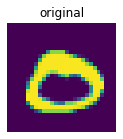

回数 =  3
loss of step(1) 29.036983489990234//loss of step(2) 34.10906219482422//loss of step(3) 38.57355499267578//
reward_sum:  -101.7196044921875


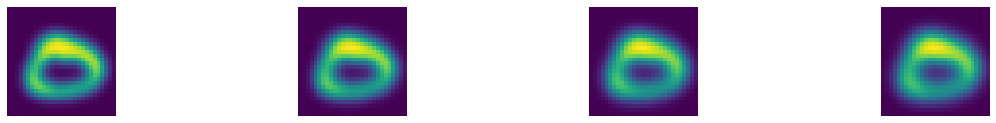

['gauss1', 'gauss1', 'gauss1']

a =  gauss2


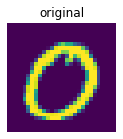

回数 =  3
loss of step(1) 38.75676727294922//loss of step(2) 46.01065444946289//loss of step(3) 51.559532165527344//
reward_sum:  -136.32696533203125


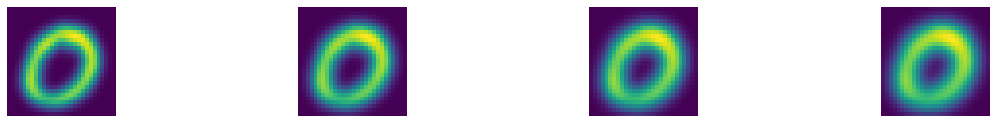

['gauss2', 'gauss2', 'gauss2']

a =  wiener


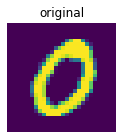

回数 =  3
loss of step(1) 16.163103103637695//loss of step(2) 8.201529502868652//loss of step(3) 1.4943106174468994//
reward_sum:  -25.85894203186035


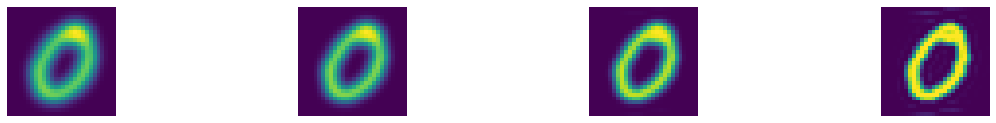

['wiener', 'wiener', 'wiener']



In [114]:
for i in range(3):
    print('a = ', action_labels[i])
    test_policy(fixed_action=i)
    print()